In [64]:
#Import the librairies
import pandas as pd
import numpy as np
import datetime
from dateutil.parser import parse
from statistics import mean, stdev
import re

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.api import ExponentialSmoothing
import itertools

from sklearn.preprocessing import MinMaxScaler

In [6]:
#Load the dataset
df = pd.read_csv('C:/Users/hendr/OneDrive/TW studie jaar 3/Rotterdam airport project/cleandata.csv')

In [7]:
#Drop an unwanted column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [9]:
#Convert the string column into a datetime format for time series
df['timestamp'] = pd.to_datetime(df['Geplande datum/tijd'], errors='coerce')

In [10]:
#Sort the dataset and rename the Pay pax column for convenience
sorted_df = df.sort_values(by='timestamp')
sorted_df['Pax_2'] = sorted_df['Pay pax']

In [146]:
df

,ï»¿Code sharing,Slot gecoÃ¶rdineerd,Vertragingscode(s),Via luchthaven(s),Vluchtnummer,Vliegtuigregistratie,Vliegtuigtype,Luchthaven,Verkeerstype,Startbaan,...,Systeemstatus,Afhandelaar,Debiteur,Gemigreerde data,Geautoriseerd,BookedPayPax,MTOW (kg),Maatschappij,Max. # zitplaatsen,timestamp
0,NaN,Nee,NaN,NaN,NaN,PH-NSC,DR-400,EHMZ,Arrival,06,...,ReadyForAuthorization,NaN,Rotterdamse Vloot (128272),Nee,Nee,NaN,1.0,NaN,4.0,2021-08-31 08:50:00
1,NaN,Nee,NaN,NaN,NaN,PH-RAD,DV-40,EHRD,Terrain,06,...,ReadyForAuthorization,NaN,Stichting Rotterdam Aviation (127571),Nee,Nee,NaN,1.0,NaN,4.0,2021-08-31 07:00:00
2,NaN,Nee,NaN,NaN,NaN,PH-VSY,PA-28,EHRD,Terrain,06,...,ReadyForAuthorization,NaN,Rotterdamse Vloot (128272),Nee,Nee,NaN,1.0,NaN,4.0,2021-08-31 07:14:00
3,NaN,Nee,NaN,NaN,LIFELN2,PH-DOC,EC-135H,EHRD,Terrain,06,...,ReadyForAuthorization,NaN,ANWB Medical Air Assistance BV (120525),Nee,Nee,NaN,3.0,NaN,8.0,2021-08-31 06:15:00
4,NaN,Nee,NaN,NaN,NaN,OO-ACC,C-525A,EBAW,Departure,06,...,ReadyForAuthorization,J,Jet Aviation Netherlands B.V. (133652),Nee,Nee,NaN,6.0,NaN,8.0,2021-08-31 07:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857156,NaN,Nee,NaN,NaN,NaN,OO-JOE,R-44,EBZZ,Arrival,NaN,...,Operational,J,Jet Aviation Netherlands B.V. (133652),Nee,Nee,NaN,1.0,NaN,4.0,2021-03-24 10:10:00
857157,NaN,Nee,NaN,NaN,NaN,D-CAWR,C-560,EDDE,Arrival,NaN,...,Operational,J,Jet Aviation Netherlands B.V. (133652),Nee,Nee,4.0,8.0,NaN,8.0,2021-06-11 05:30:00
857158,NaN,Nee,NaN,NaN,NaN,9H-WIT,PC-12,EBAW,Departure,NaN,...,Operational,J,NextGen Aviation Malta Ltd. (133983),Nee,Nee,NaN,5.0,NaN,9.0,2021-03-18 20:00:00
857159,NaN,Nee,NaN,NaN,AHO272A,D-CEFO,C-560L,LEMG,Arrival,NaN,...,Operational,J,Jet Aviation Netherlands B.V. (133652),Nee,Nee,2.0,10.0,Air Hamburg Private Jets,8.0,2020-05-28 13:36:00


# Dataset summation

In [206]:
#Aggregate the data by day (summed instead of averaged)
df_agg = sorted_df.resample('D', on='timestamp').Pax_2.sum()

In [12]:
#Take a subset of the data. There is a significant breach in the trend due to covid
df_agg = df_agg['2014-01-01':'2018-12-31']

In [13]:
#Rename the series into y for convenience
y = df_agg

In [14]:
y[y < 1] = 1

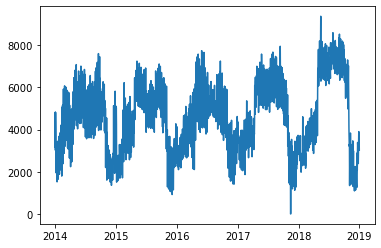

In [257]:
plt.plot(y)

# Dataset Averaging

In [243]:
#Aggregate the data by day averaged

df_avg = sorted_df[sorted_df["BookedPayPax"] != "Ja"]
df_avg = df_avg[df_avg["BookedPayPax"] != "Nee"]
df_avg = df_avg[df_avg["BookedPayPax"].isna() == False]
df_avg["BookedPayPax"] = df_avg["BookedPayPax"].astype("float")

In [253]:
df_avg = df_avg.resample('D', on= 'timestamp').BookedPayPax.mean()
#Take a subset of the data. There is a significant breach in the trend due to covid
df_avg = df_avg['2014-01-01':'2018-12-31']
df_avg[df_avg < 1] = 1


In [322]:
#Replaces Nan value with previous value
for i in range(len(np.isnan(df_avg))):
    if np.isnan(df_avg)[i] == True:
        df_avg[i] = df_avg[i-1]

1413
1414


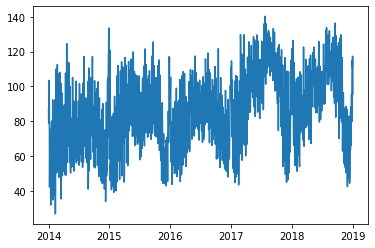

In [339]:
plt.plot(df_avg)

# Seasonal decomposition

In [267]:
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

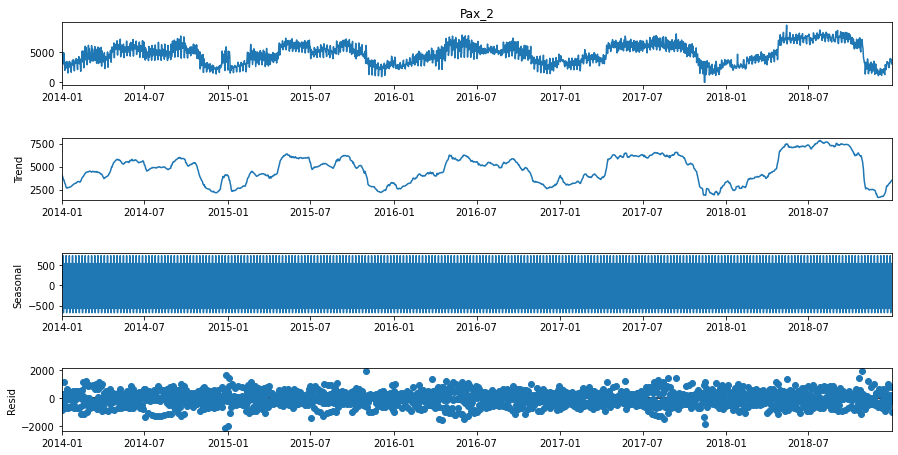

In [268]:
seasonal_decompose(y)

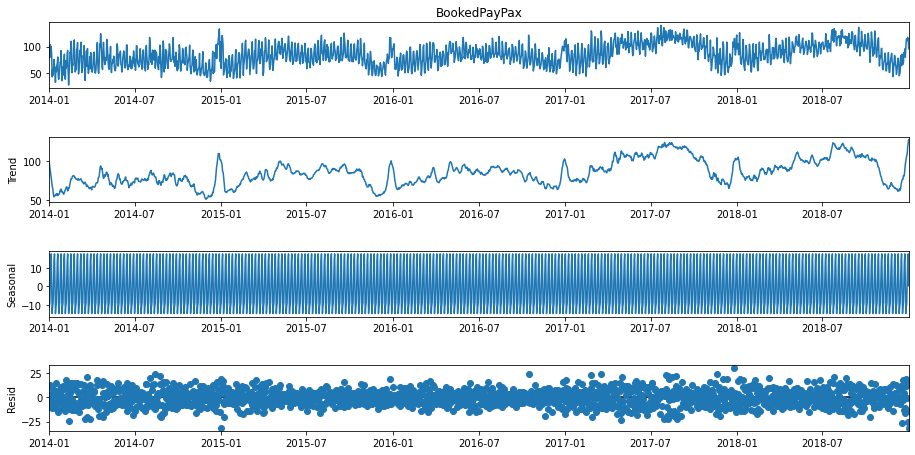

In [325]:
seasonal_decompose(df_avg)

# Stationarity tests

In [326]:
#Set up a function to test the stationarity visually
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

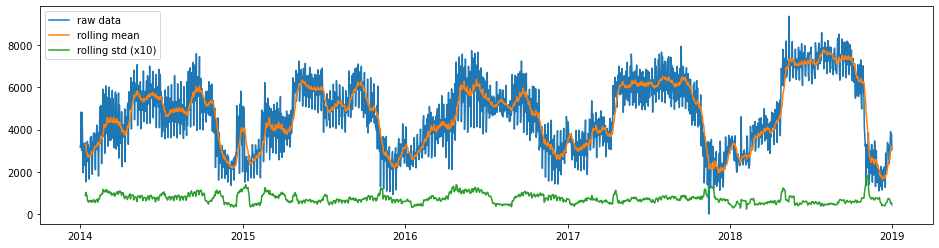

In [327]:
#Call the function
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

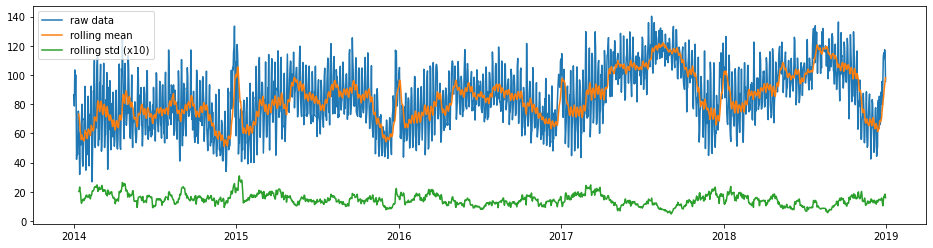

In [328]:
#Call the function
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(df_avg,'raw data')

In [340]:
#Set up a function of the Dickey-Fuller test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [341]:
#Call the function
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -3.257
P-value = 0.017
Critical values :
	1%: -3.4339800605797155 - The data is not stationary with 99% confidence
	5%: -2.8631434696839992 - The data is  stationary with 95% confidence
	10%: -2.5676236347535166 - The data is  stationary with 90% confidence


In [342]:
#Call the function
ADF_test(df_avg,'raw data')

 > Is the raw data stationary ?
Test statistic = -3.813
P-value = 0.003
Critical values :
	1%: -3.4339800605797155 - The data is  stationary with 99% confidence
	5%: -2.8631434696839992 - The data is  stationary with 95% confidence
	10%: -2.5676236347535166 - The data is  stationary with 90% confidence


In [344]:
#Partition the data into a train and test set
y_to_train = y[:'2017-12-31'] # dataset to train
y_to_val = y['2018-01-01':] # last X months for test  
predict_date = len(y) - len(y[:'2017-12-31']) # the number of data points for the test set

In [349]:
#Partition the data into a train and test set
df_avg_to_train = df_avg[:'2017-12-31'] # dataset to train
df_avg_to_val = df_avg['2018-01-01':] # last X months for test  
predict_date = len(y) - len(y[:'2017-12-31']) # the number of data points for the test set

# Simple exponential smoothing

In [350]:
#Set up a function for simple exponential smoothing
def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 3120.26
The Root Mean Squared Error of our forecasts with auto optimization is 3118.88


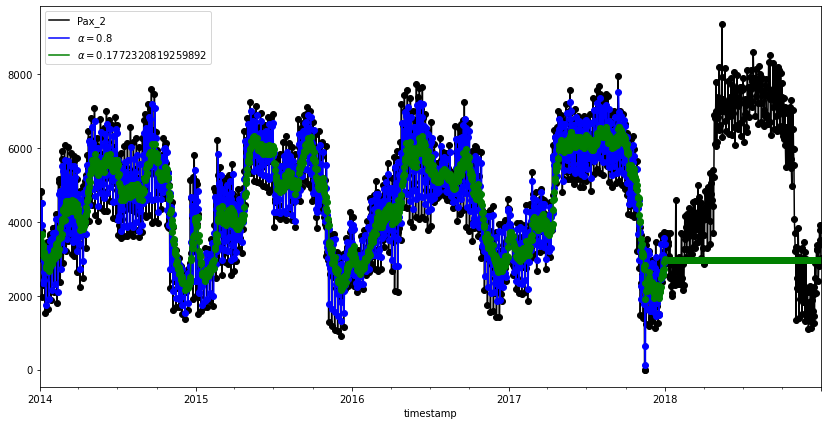

In [347]:
ses(y, y_to_train,y_to_val,0.8,predict_date) #Call the function

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 32.18
The Root Mean Squared Error of our forecasts with auto optimization is 33.8


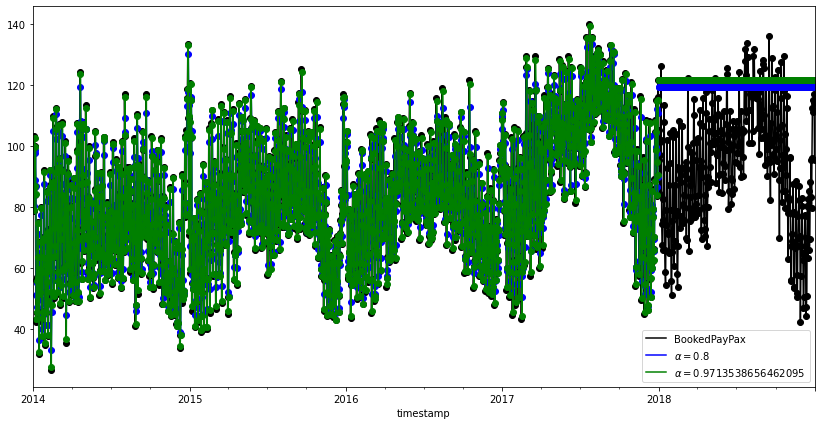

In [351]:
ses(df_avg, df_avg_to_train,df_avg_to_val,0.8,predict_date) #Call the function

# Holt's linear trend model

In [352]:
#Set up a function for Holt's Linear Trend Model
def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

The Root Mean Squared Error of Holts Linear trend 4398.13
The Root Mean Squared Error of Holts Exponential trend 82429.88


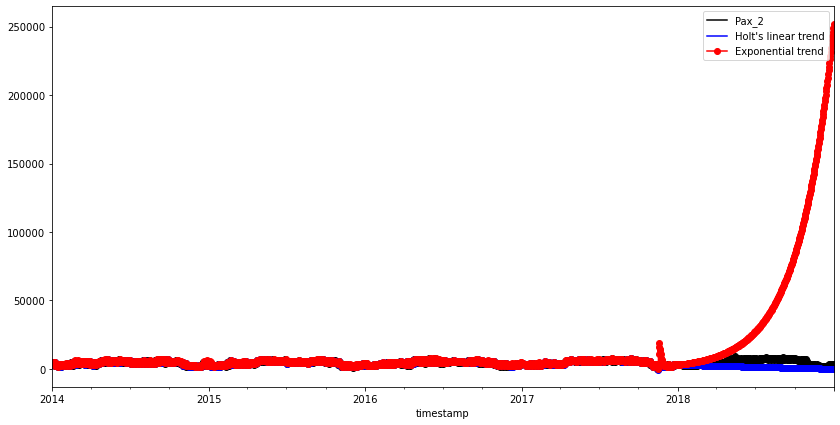

In [354]:
holt(y, y_to_train,y_to_val,0.8,0.2,predict_date) #Call the function

The Root Mean Squared Error of Holts Linear trend 1058.02
The Root Mean Squared Error of Holts Exponential trend 11200727438.24


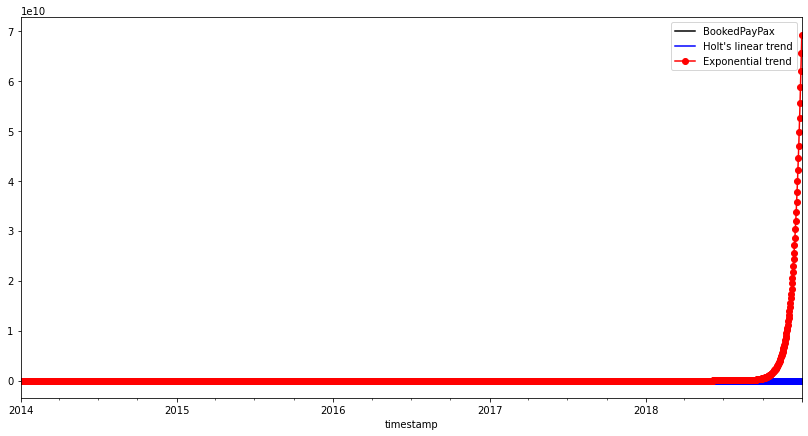

In [353]:
holt(df_avg, df_avg_to_train,df_avg_to_val,0.8,0.2,predict_date) #Call the function

# Holt Winter's Seasonal method

In [355]:
#Set up a function for Holt-Winter's Seasonal Method
def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=365 and a Box-Cox transformation 1813.48
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=365 and a Box-Cox transformation 1826.15


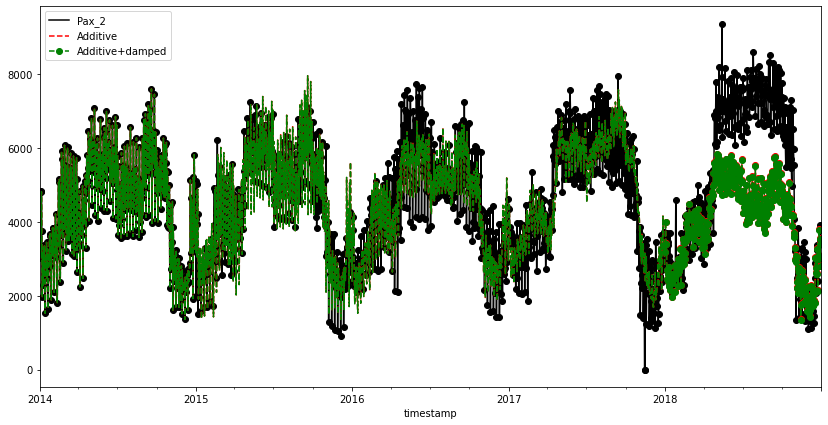

In [356]:
holt_win_sea(y, y_to_train,y_to_val,'additive',365, predict_date) #Call the function

The Root Mean Squared Error of additive trend, additive seasonal of period season_length=365 and a Box-Cox transformation 17.41
The Root Mean Squared Error of additive damped trend, additive seasonal of period season_length=365 and a Box-Cox transformation 17.8


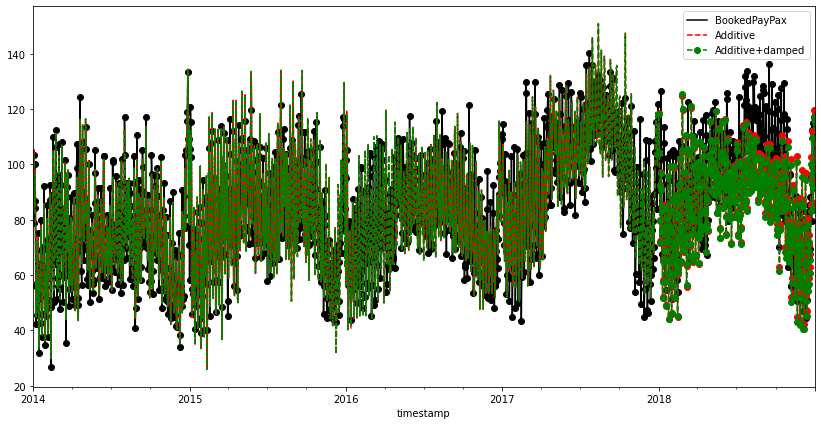

In [357]:
holt_win_sea(df_avg, df_avg_to_train,df_avg_to_val,'additive',365, predict_date) #Call the function

In [358]:
#Set up a function for the gridsearch for the SARIMA model
def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [ ]:
sarima_grid_search(y,365) #Call the function

In [ ]:
sarima_grid_search(df_avg,365) #Call the function